# Adjust height of layers

This notebook tests a new way of creating layers: instead of adding a layer of the height of snow that has fallen, we artificially set the height of the layer so that the total snow depth matches the one that has been measured by the lidar at the end of the snow event. This notebook tests this method with the Crocus simulation data as input dataset.

Let's see if this is realistic or not...

## Imports and functions

In [1]:
import xarray as xr
import dask.array
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy import f2py
import pandas as pd

import ddensity
import snowtemp

In [2]:
def fill_in_missing_variables(ds):
    '''
    Function to artificially add 'snow_surface' variable in dataset
    Args:
        ds: clean data dataset
    Returns:
    '''
    ds['snow_surface'] = ds['snow_depth']


In [3]:
def get_snow_events_bis(ds, time_window_std):
    '''
    Function that computes the dates of start and end times of snow events (snow accumulation and erosion)
    The events are defined as periods during which the snow-depth rolling standard deviation is higher than 
    a given threshold (set to 0.02 here)
    We distinguish between accumulation and erosion of snow by looking at the snow depth before and after the event
    Args:
        ds: clean dataset with 'snow_surface' variable
        time_window_std: size of the rolling window to compute standard deviation
    Returns:
        start_accumulation_indices: list of time indices corresponding to the start of an accumulation event
        start_erosion_indices: list of time indices corresponding to the end of an accumulation event
        end_accumulation_indices: list of time indices corresponding to the start of an erosion event
        end_erosion_indices: list of time indices corresponding to the end of an erosion event
    '''
    
    stdev = ds.snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
    
    snow_events_occurrences = stdev > 0.01   # booleans           # TODO make this modular
    snow_events_occurrences = np.diff(snow_events_occurrences.astype(int))   # 1 or 0
    start_time_indices = np.where(snow_events_occurrences==1)[0]
    end_time_indices = np.where(snow_events_occurrences==-1)[0]
    
    start_accumulation_indices = []
    start_erosion_indices = []
    end_accumulation_indices = []
    end_erosion_indices = []
    
    for index in range(len(start_time_indices)):
        
        start_date = start_time_indices[index]
        end_date = end_time_indices[index]
    
        start_snow_height = float(ds.snow_surface.isel(time=start_date))
        end_snow_height = float(ds.snow_surface.isel(time=end_date))
    
        if start_snow_height < end_snow_height:
            start_accumulation_indices.append(start_time_indices[index])
            end_accumulation_indices.append(end_time_indices[index])
        else:
            start_erosion_indices.append(start_time_indices[index])
            end_erosion_indices.append(end_time_indices[index])
        
    return(start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices)


In [4]:
def get_change_in_snow_depth(ds, start_events, end_events, index_of_event):
    '''
    Function to get snow height difference (absolute value) before and after an event
    Args:
        ds: dataset containing the snow-depth data ('snow_surface' variable)
        start_events: list of time indices at which the events of interest (accumulation or erosion) started
        end_events: list of time indices at which the events of interest (accumulation or erosion) ended
        index_of_event: index of event of interest in the lists of time indices
    Returns:
        difference in snow-depth between the start and end of the event
    '''
    
    start_date = start_events[index_of_event]
    end_date = end_events[index_of_event]
    
    start_snow_height = float(ds.snow_surface.isel(time=start_date))
    end_snow_height = float(ds.snow_surface.isel(time=end_date))
    difference = abs(end_snow_height - start_snow_height)
    
    return(difference)

## Data and params

In [19]:
# Get data from files

data_set_used = xr.open_dataset('crocus_snow_depth.nc')

# Pre-processing to get clean data

fill_in_missing_variables(data_set_used)

In [12]:
# Defining parameters for snow events detection

time_window_std = 11

# Initial state for compaction/temperature model, with 1 layers

max_nb_of_layers = 50
nb_iterations = 155000

ro_layer = np.zeros((max_nb_of_layers, 1))
# ro_layer[0] = 150
tf = 0
dt = 100
ro_water = 1000
ro_ice = 910
t_old = np.zeros((max_nb_of_layers, 1))
# t_old[0] = -5
jj = 0
dy_snow = np.zeros((max_nb_of_layers, 1))
# dy_snow[0] = 0.2
a1 = 0.0013
a2 = 0.021
gamma = np.zeros((max_nb_of_layers, 1))
# gamma[0] = 0
tsfc = -15
cp_snow = 2.1
melt_flag = np.zeros((max_nb_of_layers, 1))
# melt_flag[0] = 0

# Initialize arrays to keep track of variables in time

ro_layer_evolution = [ro_layer]
depth_evolution = [dy_snow]
temperature_evolution = [t_old]


## Snow events timing

In [13]:

results = get_snow_events_bis(data_set_used, time_window_std)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - 1630454400000000000)/1000000000
# 1630454400000000000 is the first time point in data_set_used > TODO make modular

end_erosion_times = data_set_used.snow_surface.isel(time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - 1630454400000000000)/1000000000

# print(end_accumulation_times, end_erosion_times)

/tmp/ipykernel_9759/28556297.py:17: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  stdev = ds.snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values


In [14]:
# Update variables at each timepoint

# Define indices of first accumulation/erosion events coming up (updated when their time is past)
accumulation_index = 0
erosion_index = 0

for i in range(nb_iterations):
    if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
        # TODO put all this in a function
        snow_depth_total = sum(dy_snow[i] for i in range(0,jj))
        ddepth = float(data_set_used.snow_surface.isel(time=end_accumulation[accumulation_index])) - snow_depth_total    # THIS HAS BEEN CHANGED SINCE LAST NTBK
        ro_layer[jj] = 150
        t_old[jj] = -5
        dy_snow[jj] = ddepth  # ??? TODO
        gamma[jj] = 0
        melt_flag[jj] = 0
        jj += 1
        accumulation_index += 1
    
    if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index] and jj>0:
        # TODO put all this in a function
        ddepth = get_change_in_snow_depth(data_set_used, start_erosion, end_erosion, erosion_index)
        if dy_snow[jj-1] > ddepth:
            dy_snow[jj-1] = dy_snow[jj-1] - ddepth
        else:
            jj -= 1
            dy_snow[jj] = 0  # ??? TODO
            ro_layer[jj] = 0  # ??? TODO
            t_old[jj] = 0
            gamma[jj] = 0
            melt_flag[jj] = 0
        erosion_index += 1
    
    # Update layers' parameters
    ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, 
                                         ro_ice, t_old, jj, dy_snow, a1, a2)
    t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, 
                                 tf, dy_snow, melt_flag)
    
    # Keep track of events
    ro_layer_evolution.append(ro_layer)
    depth_evolution.append(dy_snow)
    temperature_evolution.append(t_old)

## Plot evolution of snowpack

In [15]:
layer1 = [depth_evolution[i][0] for i in range(len(depth_evolution))]
layer2 = [layer1[i] + depth_evolution[i][1] for i in range(len(depth_evolution))]
layer3 = [layer2[i] + depth_evolution[i][2] for i in range(len(depth_evolution))]
layer4 = [layer3[i] + depth_evolution[i][3] for i in range(len(depth_evolution))]
layer5 = [layer4[i] + depth_evolution[i][4] for i in range(len(depth_evolution))]
layer6 = [layer5[i] + depth_evolution[i][5] for i in range(len(depth_evolution))]
layer7 = [layer6[i] + depth_evolution[i][6] for i in range(len(depth_evolution))]
layer8 = [layer7[i] + depth_evolution[i][7] for i in range(len(depth_evolution))]
layer9 = [layer8[i] + depth_evolution[i][8] for i in range(len(depth_evolution))]
layer10 = [layer9[i] + depth_evolution[i][9] for i in range(len(depth_evolution))]
layer11 = [layer10[i] + depth_evolution[i][10] for i in range(len(depth_evolution))]
layer12 = [layer11[i] + depth_evolution[i][11] for i in range(len(depth_evolution))]

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with dif

Text(0.5, 1.0, 'Comparison between lidar-measured and simulated snow depth')

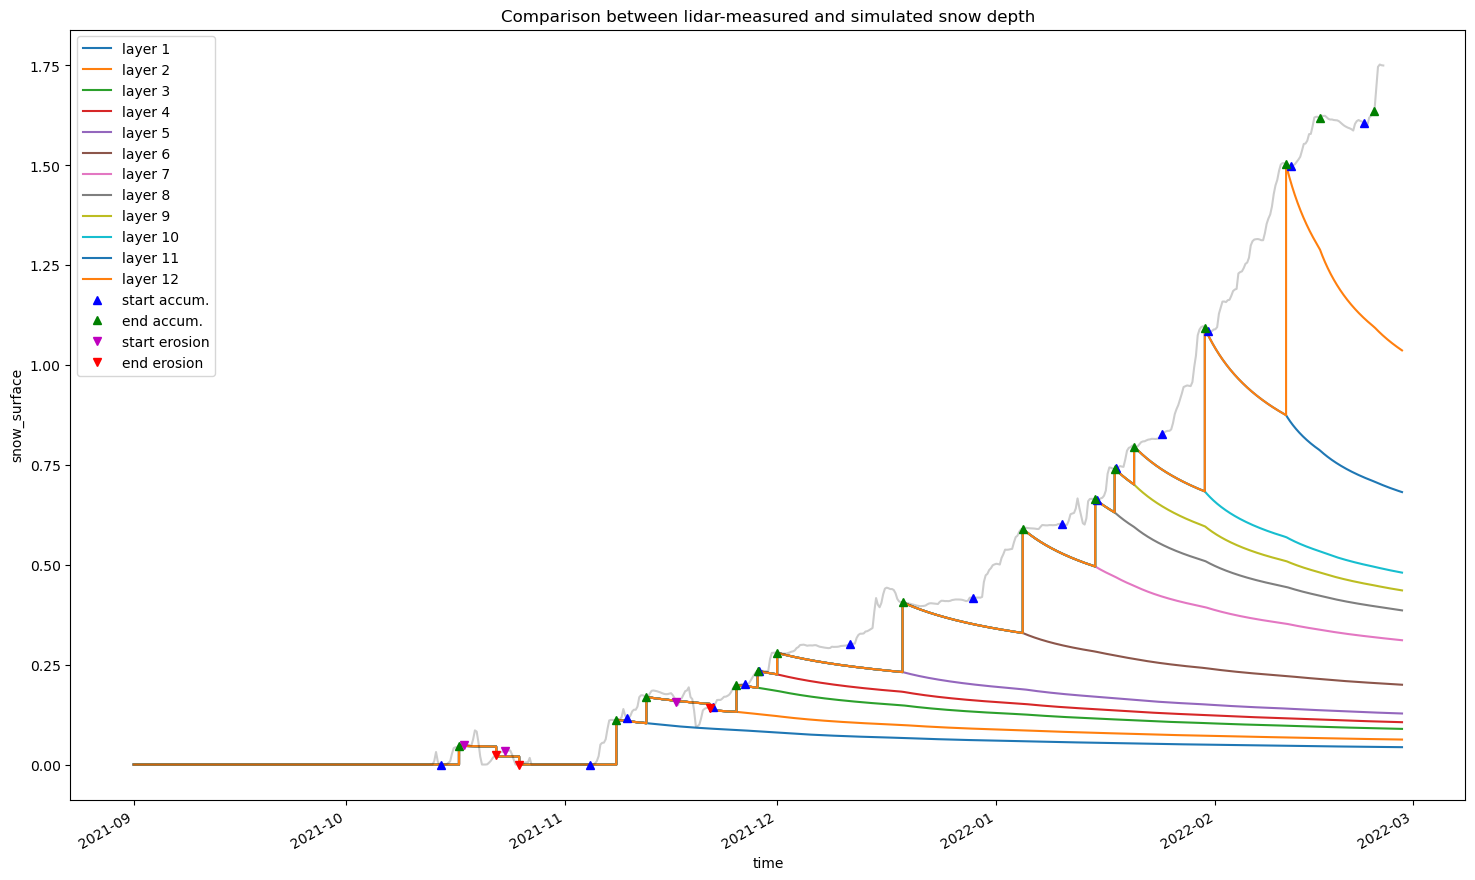

In [16]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(18, 10))

data_start_date = pd.to_datetime('2021-09-01T00:00')
times = pd.date_range(start=data_start_date,freq=str(dt)+'S',periods=nb_iterations+1)
# print(times)

plt.plot(times, layer1, label='layer 1')
plt.plot(times, layer2, label='layer 2')
plt.plot(times, layer3, label='layer 3')
plt.plot(times, layer4, label='layer 4')
plt.plot(times, layer5, label='layer 5')
plt.plot(times, layer6, label='layer 6')
plt.plot(times, layer7, label='layer 7')
plt.plot(times, layer8, label='layer 8')
plt.plot(times, layer9, label='layer 9')
plt.plot(times, layer10, label='layer 10')
plt.plot(times, layer11, label='layer 11')
plt.plot(times, layer12, label='layer 12')

# ax[0].set_ylabel('simulated snow depth')

data_set_used.snow_surface.plot(c='k', alpha=0.2)#, ax=ax[0])

data_set_used.isel(time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')#, ax=ax[0])
data_set_used.isel(time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')#, ax=ax[0])
data_set_used.isel(time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')#, ax=ax[0])
data_set_used.isel(time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')#, ax=ax[0])
plt.legend()

plt.title('Comparison between lidar-measured and simulated snow depth')

# fig.savefig('Crocus_vs_simul_snow_depth.png')